# Climate drivers

We want to look at climate features during low energy events:
1. Daily events: solar and wind lulls. Pick out most spatially extensive lull-days (separate for each season, e.g. sum lulls over all regions, pick top 10% winter days.
    - daily circulation composites: MSLP, 500gph, 200gph. Do we get H/Ls in similar positions? What is the jet doing? Maybe a plot of wind vectors - nice to see the direction and speed?
2. Anomalous seasons: sum number of events over a season and look at the largest. Sub-question: do we get consecutive seasons with lots of regions experiencing events? This might go better in an earlier notebook.
    - modes of variability: SST, the variable used to calculate SAM. What do ENSO, IOD, SAM look like?
    
And, we want to do this the other way around. Do ENSO, IOD, SAM years lead us to energy lulls?

In [1]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [2]:
# One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

walltime = '02:00:00'
cores = 4
memory = str(4 * cores) + 'GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
                     job_extra_directives=['-q normal',
                                           '-P w42',
                                           '-l ncpus='+str(cores),
                                           '-l mem='+str(memory),
                                           '-l storage=gdata/w42+gdata/rt52'],
                     local_directory='$TMPDIR',
                     job_directives_skip=["select"])
                     # python=os.environ["DASK_PYTHON"])

In [3]:
cluster.scale(jobs=1)
client = Client(cluster)

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.6.57.56:8787/status,
Dashboard: http://10.6.57.56:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.57.56:45905,Workers: 0
Dashboard: http://10.6.57.56:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
# client.close()
# cluster.close()

In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
%reload_ext autoreload
%autoreload 2

In [6]:
# import warnings

import xarray as xr
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cartopy.crs as ccrs
import cartopy
cartopy.config['pre_existing_data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data/'
cartopy.config['data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data/'

In [7]:
import functions as fn

plt_params = fn.get_plot_params()
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [8]:
years = range(1959, 2021)

data_fp = '/g/data/w42/dr6273/work/data/'

# Load masks

In [9]:
rez_mask = fn.get_rez_mask()

# Load energy source and demand data

Sources: daily wind, daily solar and monthly runoff

In [10]:
rez_100w = xr.open_zarr(
    '/g/data/w42/dr6273/work/projects/Aus_energy/data/100w_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_REZ_region_mean.zarr',
    consolidated=True
)['100w']#.compute()

In [11]:
rez_mssrd = xr.open_zarr(
    '/g/data/w42/dr6273/work/projects/Aus_energy/data/mssrd_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_REZ_region_mean.zarr',
    consolidated=True
)['mssrd']#.compute()

In [12]:
rez_ro = xr.open_zarr(
    '/g/data/w42/dr6273/work/projects/Aus_energy/data/ro_era5_monthly-averaged_sfc_'+str(years[0])+'-'+str(years[-1])+'_REZ_region_mean.zarr',
    consolidated=True
)['ro']#.compute()

Annual runoff

In [13]:
rez_ro_ann = rez_ro.resample(time='1YS').sum()

Thresholds for event definitions

In [14]:
thresh_100w = rez_100w.chunk({'time': -1}).quantile(0.25, ['time', 'region']) #4 # Close to all region-time 25th percentile of 4.19
thresh_mssrd = rez_mssrd.chunk({'time': -1}).quantile(0.25, ['time', 'region']) #170 # All region-time 25th percentile is 132.7
thresh_ro = rez_ro_ann.chunk({'time': -1}).quantile(0.25, ['time'])
thresh_t_cool = 15
thresh_t_warm = 21

### Events

In [15]:
events_100w = fn.get_events(rez_100w, thresh_100w, tail='lower')

In [16]:
events_mssrd = fn.get_events(rez_mssrd, thresh_mssrd, tail='lower')

In [17]:
events_100w_mssrd = fn.get_compound_events(rez_100w, rez_mssrd, thresh_100w, thresh_mssrd)

### Daily events over all regions

In [18]:
simul_100w = fn.concurrent_lulls(events_100w, [1, 3, 5, 7], rez_mask)
simul_mssrd = fn.concurrent_lulls(events_mssrd, [2, 3, 6, 7], rez_mask)
simul_100w_mssrd = fn.concurrent_lulls(events_100w_mssrd, [3, 7], rez_mask)

### Seasonal events over all regions

In [19]:
season_100w = fn.seasonal_mean(simul_100w).compute()
season_mssrd = fn.seasonal_mean(simul_mssrd).compute()
season_100w_mssrd = fn.seasonal_mean(simul_100w_mssrd).compute()

# Load diagnostics and climate mode indices
And then get seasonal averages

### Monthly diagnostics

HadISST SST anomalies

In [20]:
sst_fp = data_fp + 'hadisst/sst/sst_anom_hadisst_moda_sfc_'+str(years[0])+'-'+str(years[-1])+'.zarr'
sst_anoms = xr.open_zarr(sst_fp, consolidated=True)
sst_anoms = fn.seasonal_mean(sst_anoms)

ERA5 MSLP anomalies

In [21]:
mslp_fp = data_fp + 'era5/mslp/mslp_anom_era5_moda_sfc_'+str(years[0])+'-'+str(years[-1])+'.zarr'
mslp_anoms = xr.open_zarr(mslp_fp, consolidated=True)
mslp_anoms = fn.seasonal_mean(mslp_anoms)

### Climate mode indices

Nino3.4

In [22]:
nino34_fp = data_fp + 'hadisst/climate_modes/hadisst_nino34_'+str(years[0])+'-'+str(years[-1])+'.zarr'
nino34 = xr.open_zarr(nino34_fp, consolidated=True)
nino34 = fn.seasonal_mean(nino34)

DMI

In [23]:
dmi_fp = data_fp + 'hadisst/climate_modes/hadisst_dmi_'+str(years[0])+'-'+str(years[-1])+'.zarr'
dmi = xr.open_zarr(dmi_fp, consolidated=True)
dmi = fn.seasonal_mean(dmi)

SAM

In [24]:
sam_fp = data_fp + 'era5/climate_modes/era5_sam_'+str(years[0])+'-'+str(years[-1])+'.zarr'
sam = xr.open_zarr(sam_fp, consolidated=True)
sam = fn.seasonal_mean(sam)

# Monthly diagnostics on spatially extensive wind/solar/compound drought years

Figure ideas:
1. PDFs of climate mode indices, with spatially compounding months/seasons marked (crosses, lines) or the composite mean marked.
2. Composite maps of SST and MSLP (plus some other variables eventually?) over spatially compounding months/seasons. Could also show which regions have events here - maybe counts/percentage of times each region is counted.

Should be done separately for each season.

In [25]:
def get_spatial_events(da, season, q, time_name='time'):
    """
    Subsample the time steps which are spatially compounding,
    defined as when the number of regions experiencing an event
    exceeds a quantile threshold (q). Can be done by season.
    """
    months = fn.get_seasons()[season] # months in this season
    subset_da = fn.month_subset(da, months, time_name) # select data in this season
    thresh = subset_da.quantile(q, time_name) # top q extensive events
    events = subset_da.where(subset_da > thresh)
    years = events.dropna(time_name)[time_name].dt.year.values
    return years, events

In [33]:
def subset_on_events(event_da, diag_da, season, q, time_name='time'):
    """
    Obtain the diagnostic variable array over event years.
    """
    years, events = get_spatial_events(event_da, season, q, time_name)
    diag = fn.month_subset(diag_da, fn.get_seasons()[season])
    return years, events, diag

In [34]:
def composite_data(event_da, diag_da, season, q, time_name='time'):
    """
    Obtain the diagnostic variable array to be composited over event years.
    """
    years, events, diag = subset_on_events(event_da, diag_da, season, q, time_name)
    return years, diag.where(events.notnull()).mean(time_name)

In [36]:
def plot_sst_mslp(ax, sst_da, mslp_da, years):
    """
    Plot SST shading and MSLP contours on an axis.
    """
    m = 5000
    mslp_levels = np.arange(-m, m+1, 100)
    mslp_levels = [i for i in mslp_levels if i != 0]
    
    ax.coastlines(linewidths=0.1)
    
    p = p_sst.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        vmin=-1.8,
        vmax=1.8,
        cmap='RdBu_r',
        # cbar_kwargs={
        #     'location': 'bottom',
        # },
        add_colorbar=False
    )
    p_mslp.plot.contour(
        ax=ax,
        transform=ccrs.PlateCarree(),
        levels=mslp_levels,
        colors='k',
        linewidths=0.4
    )
    
    format_years = [str(i) for i in years]
    title = ', '.join(format_years)
    ax.set_title(title, fontsize=plt_params['font.size'] / 1.7, pad=0)
    
    return p

### Set variables

In [29]:
season_dict = fn.get_seasons()

In [30]:
thresh_spatial = 0.9

### Composite maps

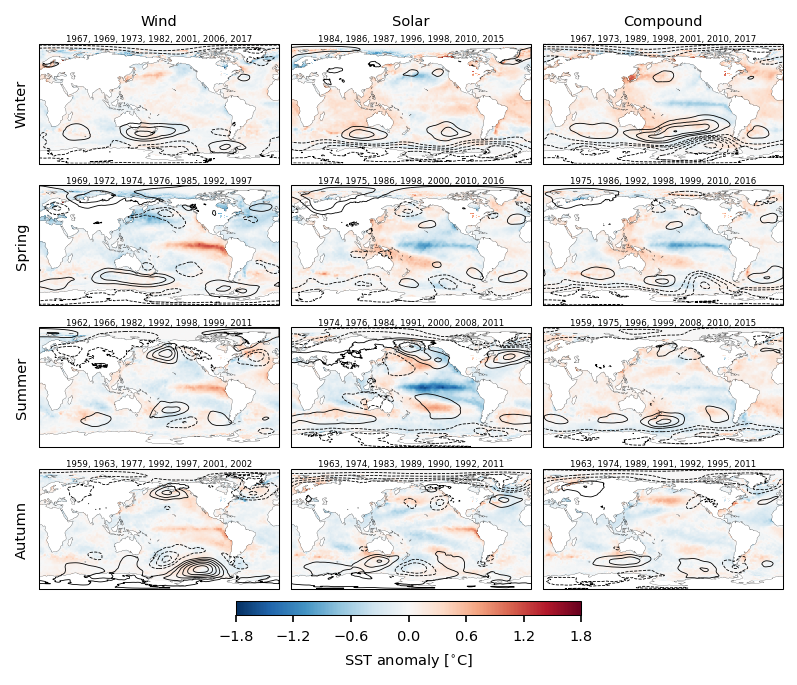

In [53]:
with plt.rc_context(plt_params):
    fig = plt.figure(dpi=150)
    
    axes = []
    for i in range(12):
        axes.append(fig.add_subplot(4, 3, i+1, projection=ccrs.PlateCarree(central_longitude=180)))
    
    i = 0
    for season in list(season_dict.keys())[1:]:
        for var in [season_100w, season_mssrd, season_100w_mssrd]:
            years, p_sst = composite_data(
                var,
                sst_anoms['sst_anom'],
                season,
                thresh_spatial
            )

            _, p_mslp = composite_data(
                var,
                mslp_anoms['mslp_anom'],
                season,
                thresh_spatial
            )

            ax = axes[i]
            p = plot_sst_mslp(ax, p_sst, p_mslp, years)
            
            i += 1
                        
    plt.subplots_adjust(hspace=0.1, wspace=0.05)
    
    axes[0].text(0.5, 1.15, 'Wind', ha='center', transform=axes[0].transAxes)
    axes[1].text(0.5, 1.15, 'Solar', ha='center', transform=axes[1].transAxes)
    axes[2].text(0.5, 1.15, 'Compound', ha='center', transform=axes[2].transAxes)
    
    axes[0].text(-0.1, 0.5, 'Winter', rotation=90, va='center', transform=axes[0].transAxes)
    axes[3].text(-0.1, 0.5, 'Spring', rotation=90, va='center', transform=axes[3].transAxes)
    axes[6].text(-0.1, 0.5, 'Summer', rotation=90, va='center', transform=axes[6].transAxes)
    axes[9].text(-0.1, 0.5, 'Autumn', rotation=90, va='center', transform=axes[9].transAxes)
    
    cb_ax1 = fig.add_axes([0.33, 0.08, 0.36, 0.02])
    cb1 = fig.colorbar(p, cax=cb_ax1, orientation='horizontal', ticks=np.arange(-1.8, 1.9, 0.6))
    cb1.ax.set_xlabel(r'SST anomaly [$^{\circ}$C]')

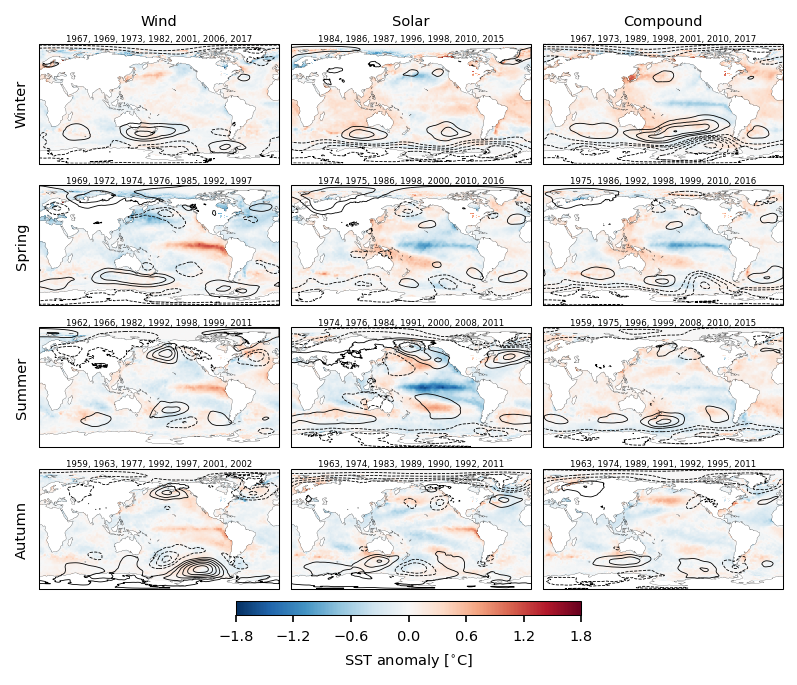

In [37]:
with plt.rc_context(plt_params):
    fig = plt.figure(dpi=150)
    
    axes = []
    for i in range(12):
        axes.append(fig.add_subplot(4, 3, i+1, projection=ccrs.PlateCarree(central_longitude=180)))
    
    i = 0
    for season in list(season_dict.keys())[1:]:
        for var in [season_100w, season_mssrd, season_100w_mssrd]:
            years, p_sst = composite_data(
                var,
                sst_anoms['sst_anom'],
                season,
                thresh_spatial
            )

            _, p_mslp = composite_data(
                var,
                mslp_anoms['mslp_anom'],
                season,
                thresh_spatial
            )

            ax = axes[i]
            p = plot_sst_mslp(ax, p_sst, p_mslp, years)
            
            i += 1
                        
    plt.subplots_adjust(hspace=0.1, wspace=0.05)
    
    axes[0].text(0.5, 1.15, 'Wind', ha='center', transform=axes[0].transAxes)
    axes[1].text(0.5, 1.15, 'Solar', ha='center', transform=axes[1].transAxes)
    axes[2].text(0.5, 1.15, 'Compound', ha='center', transform=axes[2].transAxes)
    
    axes[0].text(-0.1, 0.5, 'Winter', rotation=90, va='center', transform=axes[0].transAxes)
    axes[3].text(-0.1, 0.5, 'Spring', rotation=90, va='center', transform=axes[3].transAxes)
    axes[6].text(-0.1, 0.5, 'Summer', rotation=90, va='center', transform=axes[6].transAxes)
    axes[9].text(-0.1, 0.5, 'Autumn', rotation=90, va='center', transform=axes[9].transAxes)
    
    cb_ax1 = fig.add_axes([0.33, 0.08, 0.36, 0.02])
    cb1 = fig.colorbar(p, cax=cb_ax1, orientation='horizontal', ticks=np.arange(-1.8, 1.9, 0.6))
    cb1.ax.set_xlabel(r'SST anomaly [$^{\circ}$C]')

### Climate modes PDFS

In [61]:
b = np.linspace(-2.5, 2.5, 10)
b, d = fn.hist_data(nino34['nino34'], b)

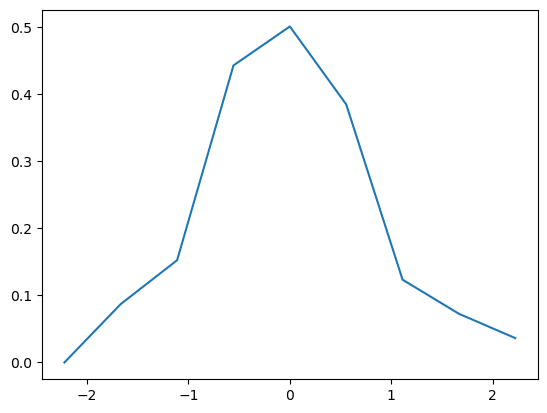

In [62]:
plt.plot(b, d)

# Close cluster

In [62]:
client.close()
cluster.close()